<center>

--- 

# Proyecto de Ciencia de Datos
## Convolución de Winograd
### Álvaro Laguna García
### Grado en Ciencia de Datos e Inteligencia Artificial
<img src=https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Logotipo%20con%20Leyenda/LOGOTIPO%20leyenda%20color%20PNG.png width=25% height=25%>

---
</center>


La convolución de Winograd es una convolución que utiliza el algoritmo Winograd para reducir la cantidad de multiplicaciones necesarias para realizar la convolución a cambio de realizar más sumas.

La idea de la convolución de Winograd es transformar tanto la imagen como el filtro a un nuevo dominio, para poder efectuar la convolución con productos de Hadamard (multiplicación elemento a elemento) en lugar de convoluciones, ahorrando así multiplicaciones. La idea de transformar la imagen y el filtro a un nuevo dominio para realizar la convolución no es nueva, por ejemplo, se podría usar la transformada rápida de Fourier (FFT) para transformar la imagen y el filtro al dominio de la frecuencia. De hecho, Winograd funciona de manera similar, cambiando de dominio muestreando la señal en suficientes puntos para poder reconstruir la señal original, pero la principal diferencia es que Winograd utiliza puntos reales en lugar de puntos complejos, lo que hace quelos productos que se efectúan en la convolución de Winograd sean cuatro veces más rápidos que la convolución FFT.

La convolución de Winograd se implementa de la siguiente manera:
- La imagen se divide en parches, cuyo tamaño puede ser decidido por el usuario, con una superposición del tamaño del filtro - 1 entre parches (esta es la superposición mínima para no perder información). La imagen puede ser rellenada con ceros para que todos los parches tengan el mismo tamaño, y estos ceros se pueden eliminar después de la convolución.

- Se calculan las matrices `Y`, `X` y `W` para cada dimensión, que se utilizan para transformar tanto el parche como el filtro a un nuevo dominio. Cabe destacar que estas matrices se calculan una sola vez para cada tamaño de parche y filtro, por lo que no es necesario calcularlas cada vez que se realiza una convolución.

- El parche se transforma usando `X`, el filtro se transforma usando `W` y, como ambos están en el dominio de frecuencia, se multiplican usando el producto de Hadamard (multiplicación elemento a elemento) por el teorema de la convolución.

- El resultado se transforma de nuevo al dominio espacial usando `Y`. Se hace siguiendo la siguiente fórmula: 
    $$ x * w = Y^T \cdot [(X^T \cdot x \cdot X) \odot (W \cdot w \cdot W^T)] \cdot Y $$

    Donde:
    - $x$ es el parche.
    - $w$ es el filtro.
    - $*$ es la convolución.
    - $\cdot$ es la multiplicación matricial.
    - $\odot$ es el producto de Hadamard (multiplicación elemento a elemento).

- Los parches se concatenan para formar la imagen de salida.


La convolución de Winograd tiene las siguientes ventajas:

- Puede ser más rápida que la convolución tradicional para tamaños de filtro pequeños y dispositivos con baja potencia computacional, ya que sacrifica multiplicaciones por sumas, que son más económicas (a menos que esté utilizando una GPU o tu CPU tenga instrucciones SIMD (*Single Instruction Multiple Data*) para multiplicaciones, en cuyo caso la convolución tradicional vectorizada puede ser más rápida)
- Es más rápida que la convolución FFT, ya que, como se mencionó anteriormente, las multiplicaciones complejas son cuatro veces más caras que las multiplicaciones reales.

La convolución Winograd tiene las siguientes desventajas:

- Dado que estamos utilizando puntos para calcular las matrices, las matrices no son exactas y el error aumenta con el tamaño de la matriz. Esto no es un problema para matrices pequeñas, pero puede ser un problema para matrices grandes.
- La convolución Winograd no se puede usar con tamaños de parche grandes (no mayores de alrededor de 10), ya que las matrices serían numéricamente inestables.

En este proyecto se implementa la convolución de Winograd para imágenes 2D (escala de grises), y para implementar la convolución para imágenes 3D (RGB) se utiliza la convolución de Winograd para cada canal de color por separado, ya que, aunque teóricamente se podría implementar la convolución de Winograd para imágenes 3D, en las pruebas realizadas se ha observado que la convolución de Winograd para imágenes 3D es muy inestable numéricamente, otorgando números muy grandes.

Teóricamente, puede implementarse de la siguiente manera:

$$\mathcal{G} * \mathcal{D} =[(\mathcal{G} \times_{n=1}^N W) \odot (\mathcal{D} \times_{n=1}^N X)] \times_{n=1}^N Y^T$$

Con las siguientes definiciones:
- $\mathcal{G}$ es el tensor de entrada multidimensional, que en este caso es la imagen.
- $\mathcal{D}$ es el tensor de filtro multidimensional, que en este caso es el kernel.
- $\mathcal{G} \times_{n=1}^N G$ es una abreviatura de $\mathcal{G} \times_1 G_1\times_2 G_2\dots \times_N G_N,$
- $\times_n$ representa el producto modo n, también conocido como el producto modo n tensor-matriz, que es una generalización
del producto matriz-vector a tensores, que se realiza primero aplanando el tensor a lo largo de la n-ésima dimensión,
dando como resultado una matriz de tamaño $I_n \times \prod_{i \neq n} I_i$, donde $I_i$ es el tamaño de la i-ésima dimensión del
tensor, luego se multiplica el tensor aplanado con la matriz, y finalmente se remodela el resultado a la forma original del tensor,
pero con la n-ésima dimensión reemplazada por la segunda dimensión de la matriz.

La generación de las matrices `Y`, `X` y `W` es la misma que en el caso 2D, para cada dimensión pueden ser diferentes,
dependiendo del tamaño del *kernel* y la salida.

Todo esto se puede hacer utilizando `tensorly.tenalg.multi_mode_dot`, pero no se implementa aquí porque no es estable.

La implementación de la convolución de Winograd para convoluciones 3D se realiza de la siguiente manera:

```python    
def winograd_chunk_3D(patch, kernel, winograd_matrices):
    part1 = tensorly.tenalg.multi_mode_dot(patch, [t[1] for t in winograd_matrices], list(range(parche.ndim)))
    part2 = tensorly.tenalg.multi_mode_dot(kernel, [t[2] for t in winograd_matrices], list(range(núcleo.ndim)))
    part3 = part1 * part2
    return tensorly.tenalg.multi_mode_dot(part3, [t[0] for t in winograd_matrices], list(range(parte3.ndim)))
```

Siendo `winograd_matrices` una lista de tuplas de la forma `(Y, X, W)`, donde `Y`, `X` y `W` son las matrices de transformación para cada dimensión.

# Índice:
- [Importación de librerías](#-Importación-de-librerías)
- [Comprobación de la implementación](#-Comprobación-de-la-implementación)
- [Comprobación del rendimiento](#-Comprobación-del-rendimiento)
    - [Modo Alto Rendimiento](#-Modo-Alto-Rendimiento)
    - [Modo Bajo Rendimiento](#-Modo-Bajo-Rendimiento)
    
- [Ejemplo de uso con imágenes](#-Ejemplo-de-uso-con-imágenes)
    
    - [Modo Alto Rendimiento para Imágenes](#-Modo-Alto-Rendimiento-Para-Imágenes)
    - [Modo Bajo Rendimiento para Imágenes](#-Modo-Bajo-Rendimiento-Para-Imágenes)

- [Conclusiones](#-Conclusiones)
- [Referencias](#-Referencias)

# Importación de librerías

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pathlib
from typing import Tuple

from winograd_conv import WinogradConv2D, WinogradConv3D, convolve_with_winograd_and_tf

# Comprobación de la implementación

Primero, veamos que la convolución de Winograd implementada es correcta, comparándola con la convolución tradicional:

In [2]:
image_size = (1000, 1000)
image = np.random.rand(*image_size)

kernel_size = (5, 5)
kernel = np.random.rand(*kernel_size)

patch_size = (10, 10)

In [3]:
convolve_with_winograd_and_tf(image, kernel, patch_size, plot=False);

Are the results equal? True


# Comprobación del rendimiento

Vamos a hacer unas pruebas para ver si la convolución de Winograd, para imágenes grandes, es más rápida que la convolución tradicional implementada en *TensorFlow*.

In [4]:
winograd_conv2d = WinogradConv2D(image.shape, kernel.shape, patch_size, strides=(1, 1))

## Modo alto rendimiento

In [5]:
%%timeit
winograd_conv2d(image, kernel)

53.6 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%%timeit
tf.nn.conv2d(image.reshape(1, *image.shape, 1), kernel.reshape(*kernel.shape, 1, 1), strides=[1, 1, 1, 1], padding='VALID')

45.9 ms ± 7.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Modo bajo rendimiento

In [7]:
%%timeit
winograd_conv2d(image, kernel)

189 ms ± 17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit
tf.nn.conv2d(image.reshape(1, *image.shape, 1), kernel.reshape(*kernel.shape, 1, 1), strides=[1, 1, 1, 1], padding='VALID')

256 ms ± 59.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Vemos que, en este caso, en el modo alto rendimiento, la convolución tradicional es ligeramente más rápida que la convolución de Winograd, pero en el modo bajo rendimiento, la convolución de Winograd es más rápida que la convolución tradicional.

# Ejemplo de uso con imágenes

Nos descargamos el *dataset* de flores de *TensorFlow*:

In [9]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

image_count = len(list(data_dir.glob('*/*.jpg')))

roses = list(data_dir.glob('roses/*'))

Creamos unos filtros de ejemplo:

In [10]:
gaussian_blur_5x5 = np.array([[1, 4, 6, 4, 1],
                              [4, 16, 24, 16, 4],
                              [6, 24, 36, 24, 6],
                              [4, 16, 24, 16, 4],
                              [1, 4, 6, 4, 1]]) / 256.0
gaussian_blur_5x5_3d = np.stack([gaussian_blur_5x5] * 3, axis=-1)  # Blur across all 3 channels for RGB images

sharpen = np.array([[-1, 0, -1],
                    [0, 5, 0],
                    [-1, 0, -1]])
sharpen_3d = np.stack([sharpen] * 3, axis=-1)  # Sharpen across all 3 channels for RGB images

Nos quedamos con la primera imagen:

In [11]:
# Get one image in a numpy array
img = tf.keras.preprocessing.image.load_img(roses[0])
img_array_rgb = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_grayscale = tf.image.rgb_to_grayscale(img_array_rgb).numpy().reshape(img_array_rgb.shape[:-1])

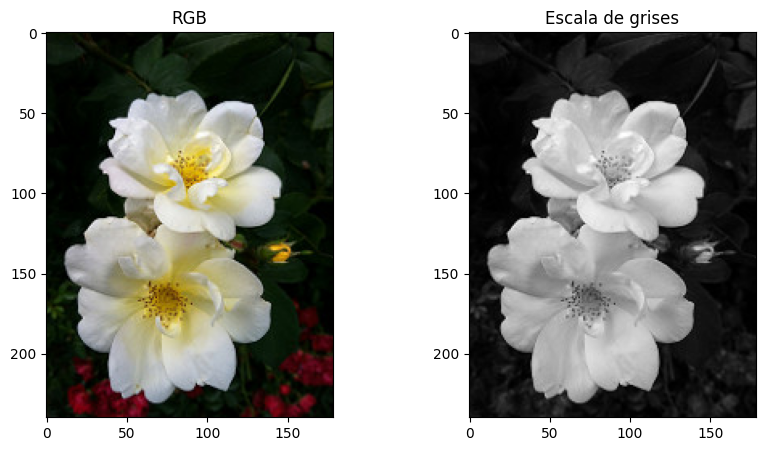

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_array_rgb)
plt.title('RGB')
plt.subplot(1, 2, 2)
plt.imshow(img_grayscale, cmap='gray')
plt.title('Escala de grises')
plt.show()

La convertimos a escala de grises para poder aplicar la convolución 2D:

Are the results equal? True


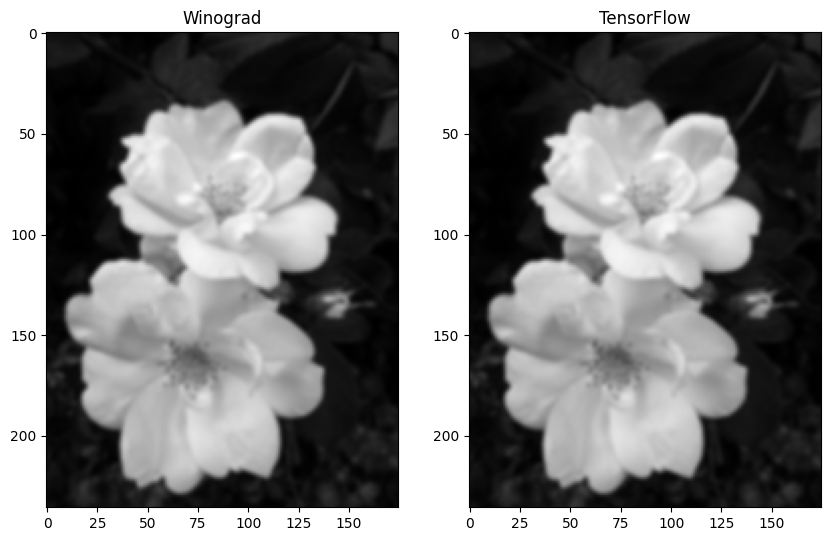

In [13]:
convolve_with_winograd_and_tf(img_grayscale, gaussian_blur_5x5, patch_size=(10, 10), plot=True);

Are the results equal? False
The maximum difference is 5.438923231793069e-07 > 2.685755325317383e-05


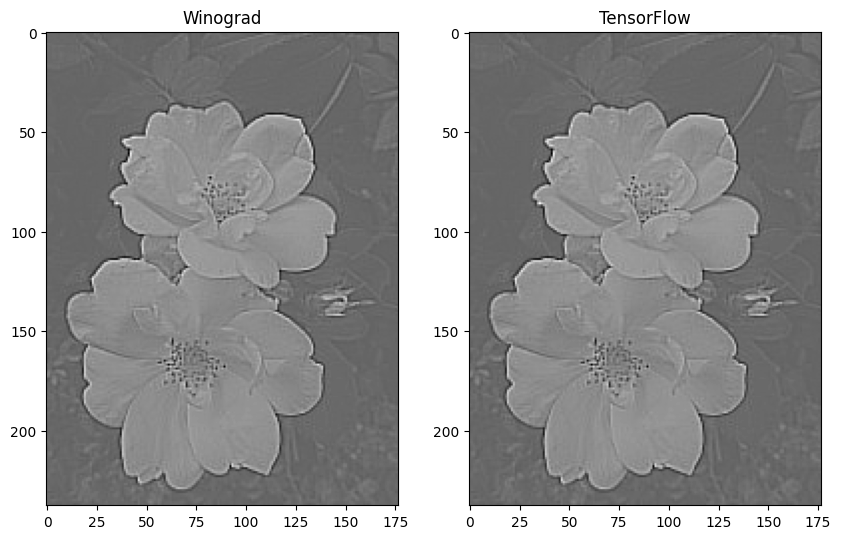

In [14]:
convolve_with_winograd_and_tf(img_grayscale, sharpen, patch_size=(10, 10), plot=True);

Como vemos, la convolución de Winograd funciona, aunque en el segundo caso, la inestaibilidad numérica hace que los valores sean ligéramente diferentes.

In [15]:
winograd_conv2d = WinogradConv2D(img_grayscale.shape, gaussian_blur_5x5.shape, (5, 5), strides=(1, 1))

Repitamos la prueba de rendimiento con imágenes:

## Modo alto rendimiento con imágenes pequeñas

In [16]:
%%timeit
winograd_conv2d(img_grayscale, gaussian_blur_5x5)

26.2 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
img_grayscale_reshape = img_grayscale.reshape(1, *img_grayscale.shape, 1)
gaussian_blur_5x5_reshape = gaussian_blur_5x5.reshape(*gaussian_blur_5x5.shape, 1, 1)

In [18]:
%%timeit
tf.nn.conv2d(img_grayscale_reshape, gaussian_blur_5x5_reshape, strides=[1, 1, 1, 1], padding='VALID').numpy()

1.9 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Modo bajo rendimiento con imágenes pequeñas

In [19]:
%%timeit
winograd_conv2d(img_grayscale, gaussian_blur_5x5)

43.8 ms ± 3.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%%timeit
tf.nn.conv2d(img_grayscale_reshape, gaussian_blur_5x5_reshape, strides=[1, 1, 1, 1], padding='VALID').numpy()

9.62 ms ± 2.81 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


En este caso, con una imagen pequeña, la convolución tradicional es más rápida que la convolución de Winograd en ambos modos.

# Conclusiones

La convolución de Winograd, sobre el papel y dependiendo de en qué dispositivo se ejecute, puede ser más rápida que la convolución tradicional, debido a que sacrifican multiplicaciones por sumas, que son más económicas, pero mi implementación de la convolución de Winograd en Python no puede competir con la implementación de la convolución tradicional en *TensorFlow*, ya que *TensorFlow* está implementado en C++ y CUDA y utiliza instrucciones SIMD para multiplicaciones, lo que hace que la convolución tradicional sea más rápida que la convolución de Winograd en Python. Si se implementara la convolución de Winograd en C++, paralelizando y vectorizando el código, podría ser más rápida que la convolución tradicional. Se podría también implementar como una capa de *TensorFlow*, pero no se ha hecho por falta de tiempo.

- [On Improving the Numerical Stability of Winograd Convolutions](https://openreview.net/pdf?id=H1ZaRZVKg)
- [Fast Algorithms for Convolutional Neural Networks](https://arxiv.org/pdf/1509.09308.pdf)
    - [Appendices](https://openaccess.thecvf.com/content_cvpr_2016/supplemental/Lavin_Fast_Algorithms_for_2016_CVPR_supplemental.pdf)
- [Convolutional Neural Networks](https://drive.google.com/file/d/1bVFhIa0tB0dP18JYEUilmWRIJF_MPkzh/view?usp=sharing)
    - [Presentation](https://drive.google.com/file/d/1UaAh-6MTxNTkKAluGqvkplIOyNpT1MpB/view?usp=sharing)
    - [GitHub](https://github.com/Pabloo22/dlfs)